Zespoły klasyfikatorów
----

In [ ]:
!git clone https://github.com/matzim95/ML-datasets

### Zdefiniowane wcześniej funkcje:

In [1]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ML-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average, zero_division = 0)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

import matplotlib.ticker as ticker

def plot_confusion_matrix(cm, classes, title=None, title_appendix = '', cmap = plt.cm.Blues):

    if title_appendix:
        title_appendix = f'({title_appendix})'

    if title is None:
        title = f'Confusion Matrix {title_appendix}'

    fig, ax = plt.subplots(figsize = (10,5))

    img = ax.imshow(cm, cmap = cmap)

    ax.figure.colorbar(img, ax = ax)

    # Określanie lokalizacji ticków
    ticks = np.arange(len(classes))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # Ustawienie lokalizatora
    ax.xaxis.set_major_locator(ticker.FixedLocator(ticks))
    ax.yaxis.set_major_locator(ticker.FixedLocator(ticks))

    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    fmt = '.2f' if cm.dtype =='float' else 'd'

    for y, row in enumerate(cm):
        for x, cell in enumerate(row):
            ax.text(x,y, format(cell, fmt), ha ='center', color = 'white' if cell > cm.max()/2 else 'black')

    # Teraz możemy bezpiecznie użyć set_xticklabels() i set_yticklabels()
    ax.set_xticklabels(classes, rotation = 90)
    ax.set_yticklabels(classes, rotation = 0)

    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype('float') /confusion_matrix.sum(axis = 1)[np.newaxis].T

### Gotowa funkcja do liczenia modelu:

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold

def count_model(classifier, kfold, X,y, classes, params = None, scaling = None, numeric_features = None, results = None, plot = None, print_params = None):
    
    # Dodanie parametrów do klasyfikatora:
    if params is None:
        params = {}
        clf = classifier(**params)
    else:
        clf = classifier(**params)
    
    # Listy, które będą przechowywać wyniki:
    predicted = []
    target = []
    
    
    # Definiowanie skalera:
    
    if scaling == 'minmax':
        scaler = MinMaxScaler()
    elif scaling == 'standard':
        scaler = StandardScaler()
    elif scaling is None:
        pass
    else:
        print('Wybierz scaler z listy: minmax, standard')

    # Model z walidacją krzyżową:    
    for train_index, test_index in kfold.split(X,y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

    if scaling and numeric_features:
        
        # Skalowanie zbiorów treninowego i testowego, jeśli podaliśmy skaler, dla każdej iteracji, walidacji krzyżowej:
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        
        X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
        X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])
        
        X_train = X_train_scaled
        X_test = X_test_scaled
    
    # Model:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    target = np.concatenate((target, y_test))
    predicted = np.concatenate((predicted, y_pred))
    
    
    # Print parametrów, resultatów i wykresów:
    if print_params:
        print('PARAMS:\n\n', clf.get_params(),'\n')

    if results:
        print('RESULTS:\n')
        print_results(calculate_metrics(target, predicted))

    if plot:
        print('PLOT:\n')
        plot_confusion_matrix(confusion_matrix(target, predicted), classes)
        plot_confusion_matrix(normalize_confusion_matrix(confusion_matrix(target, predicted)), classes)



Przetestujmy jednak najpierw jak działa bagging:

In [3]:
X, y, classes = prepare_dataset('wine')

In [4]:
n = 50
inds = np.array(range(len(X)))

In [5]:

for i in range(5):

    choosen = np.random.choice(inds, n)
    X_bootstrap = X.iloc[choosen]

    print(f'Próba bootstrapowa: {i}')

    print(f'Długość zbioru X_bootstrap: {len(X_bootstrap)}, bez duplikatów: {len(X_bootstrap.drop_duplicates())}')


Próba bootstrapowa: 0
Długość zbioru X_bootstrap: 50, bez duplikatów: 45
Próba bootstrapowa: 1
Długość zbioru X_bootstrap: 50, bez duplikatów: 43
Próba bootstrapowa: 2
Długość zbioru X_bootstrap: 50, bez duplikatów: 41
Próba bootstrapowa: 3
Długość zbioru X_bootstrap: 50, bez duplikatów: 49
Próba bootstrapowa: 4
Długość zbioru X_bootstrap: 50, bez duplikatów: 42


## Budowa modelu na danych rzeczywistych

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Skalujemy dane, bo skorzystamy z bazowego estymatora SVM w Bagging Classifier:

In [9]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

In [10]:
X_scaled_train = minmax.fit_transform(X_train)
X_scaled_test = minmax.transform(X_test)

X_train[:] = X_scaled_train
X_test[:] = X_scaled_test

In [11]:
X_train.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,0.513288,0.283813,0.535023,0.459307,0.373326,0.425553,0.335150,0.441935,0.368041,0.327789,0.376159,0.508783,0.371412
std,0.212785,0.209406,0.156887,0.178603,0.170953,0.220349,0.213267,0.237031,0.177069,0.205323,0.185760,0.266678,0.244785
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.352632,0.147658,0.449198,0.331186,0.234568,0.238095,0.167391,0.264151,0.264984,0.165529,0.229675,0.258555,0.179466
50%,0.531579,0.191446,0.534759,0.458763,0.345679,0.441392,0.359783,0.396226,0.356467,0.296075,0.390244,0.579848,0.319725
75%,0.665789,0.435845,0.652406,0.561856,0.487654,0.604396,0.501630,0.599057,0.485804,0.427261,0.495935,0.721483,0.568513
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Bagging Classifier:

In [12]:
model = BaggingClassifier(estimator = SVC(kernel = 'rbf', C=0.1), n_estimators = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [13]:
print_results(calculate_metrics(y_test, y_pred))

Results for classifier
----
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 score:  1.0
  Mislabeled 0 out of 36




PARAMS:

 {'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0': 0.0, 'estimator__decision_function_shape': 'ovr', 'estimator__degree': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__max_iter': -1, 'estimator__probability': False, 'estimator__random_state': None, 'estimator__shrinking': True, 'estimator__tol': 0.001, 'estimator__verbose': False, 'estimator': SVC(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 5, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 

RESULTS:

Results for classifier
----
  Accuracy:  0.6949152542372882
  Precision: 0.4982456140350877
  Recall:    0.6315789473684211
  F1 score:  0.5482456140350876
  Mislabeled 18 out of 59


PLOT:



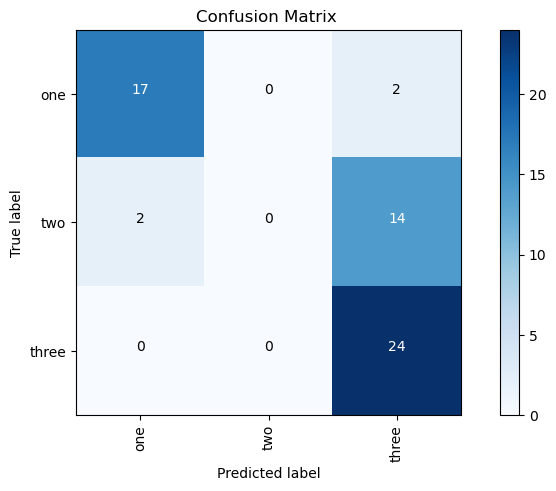

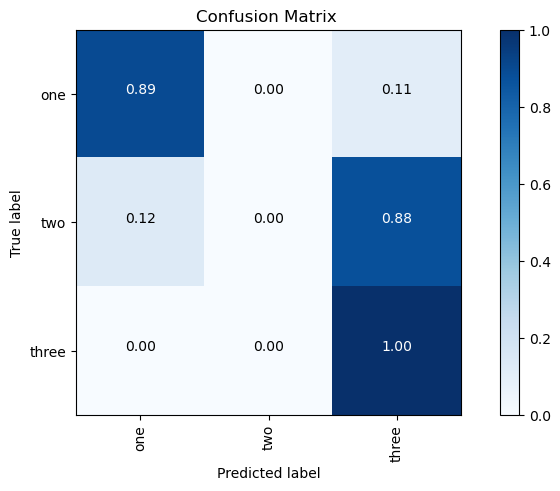

In [14]:
count_model(BaggingClassifier,
            StratifiedKFold(3),
            X,
            y,
            classes,
            params = {'estimator': SVC(), 'n_estimators':5},
            scaling = None,
            numeric_features = None,
            results = True,
            plot = True,
            print_params = True);

#### Random Forrest

Spróbujmy czy uda nam się uzyskać lepszy wynik na zbiorze glass, przy użyciu random forresta:

In [15]:
X, y, classes = prepare_dataset('glass')

Choć random forrest tego nie wymaga, zróbmy sobie powtórkę z dyskretyzacji:

In [16]:
X['Sodium'].unique()

array([13.64, 13.89, 13.53, 13.21, 13.27, 12.79, 13.3 , 13.15, 14.04,
       13.  , 12.72, 12.8 , 12.88, 12.86, 12.61, 12.81, 12.68, 14.36,
       13.9 , 13.02, 12.82, 14.77, 12.78, 13.38, 12.98, 12.87, 12.56,
       13.08, 12.65, 12.84, 12.85, 12.57, 12.69, 13.29, 12.74, 14.21,
       12.71, 13.73, 12.73, 13.49, 13.19, 13.99, 13.58, 13.72, 13.2 ,
       13.43, 13.14, 12.45, 12.99, 13.48, 13.39, 13.6 , 13.81, 13.51,
       14.17, 13.69, 13.05, 13.12, 13.31, 14.86, 13.09, 13.34, 13.44,
       13.92, 13.25, 13.41, 14.25, 13.36, 13.24, 13.4 , 13.01, 12.55,
       12.93, 12.9 , 12.2 , 12.67, 12.96, 12.75, 12.35, 12.62, 13.8 ,
       13.83, 11.45, 10.73, 12.3 , 14.43, 11.23, 11.02, 12.64, 13.46,
       13.1 , 13.56, 13.23, 12.94, 13.78, 13.55, 13.98, 13.75, 13.7 ,
       13.71, 13.33, 12.89, 13.65, 12.16, 14.32, 13.42, 13.04, 14.03,
       13.5 , 14.19, 14.01, 11.56, 11.03, 12.97, 14.  , 13.79, 14.46,
       14.09, 14.4 , 14.99, 14.15, 14.56, 17.38, 15.79, 13.88, 14.85,
       14.2 , 14.75,

In [17]:
print(pd.cut(X['Sodium'], 3).unique())
print(pd.cut(X['Sodium'], 3).value_counts())

[(12.947, 15.163], (10.723, 12.947], (15.163, 17.38]]
Categories (3, interval[float64, right]): [(10.723, 12.947] < (12.947, 15.163] < (15.163, 17.38]]
(12.947, 15.163]    154
(10.723, 12.947]     58
(15.163, 17.38]       2
Name: Sodium, dtype: int64


In [18]:
print(pd.qcut(X['Sodium'], 3).unique())
print(pd.qcut(X['Sodium'], 3).value_counts())

[(13.02, 13.64], (13.64, 17.38], (10.729000000000001, 13.02]]
Categories (3, interval[float64, right]): [(10.729000000000001, 13.02] < (13.02, 13.64] < (13.64, 17.38]]
(10.729000000000001, 13.02]    74
(13.02, 13.64]                 72
(13.64, 17.38]                 68
Name: Sodium, dtype: int64


In [19]:
def equal_lenght(column, n_bins):
    indices, bins = pd.cut(column, n_bins, retbins = True, labels = False, duplicates = 'drop')

    return indices.map(dict(enumerate(bins)))

lenght_bin = lambda x: equal_lenght(x, 5)

X_l = X.apply(lenght_bin)

In [20]:
def equal_frequency(column, n_bins):
    indices, bins = pd.qcut(column, n_bins, retbins = True, labels = False, duplicates = 'drop')

    return indices.map(dict(enumerate(bins)))

freq_bin = lambda x: equal_frequency(x, 5)

X_f = X.apply(freq_bin)

Random Forrest wyrenujemy jednak na oryginalnych danych:

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print_results(calculate_metrics(y_test, y_pred))

Results for classifier
----
  Accuracy:  0.6976744186046512
  Precision: 0.8246963562753037
  Recall:    0.6579365079365079
  F1 score:  0.6840777051561364
  Mislabeled 13 out of 43




PARAMS:

 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 

RESULTS:

Results for classifier
----
  Accuracy:  0.7380952380952381
  Precision: 0.5645833333333333
  Recall:    0.5388888888888889
  F1 score:  0.5333122496310352
  Mislabeled 11 out of 42


PLOT:



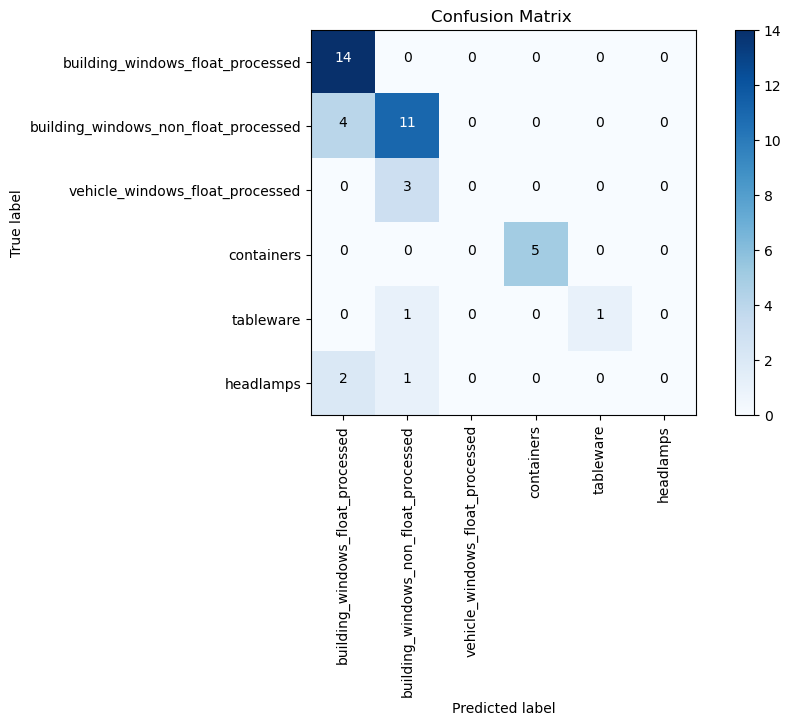

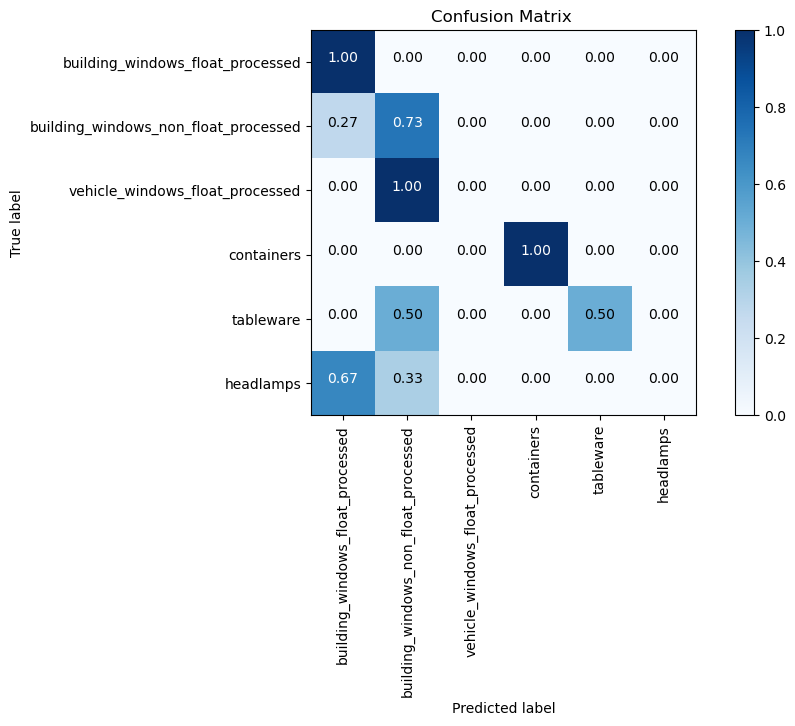

In [22]:
count_model(RandomForestClassifier,
            StratifiedKFold(5),
            X,
            y,
            classes,
            params = None,
            scaling = None,
            numeric_features = None,
            results = True,
            plot = True,
            print_params = True)

A jaki wynik zwróci BaggingClassifier z SVM?

In [23]:
X.columns

Index(['refractive index', 'Sodium', 'Magnesium', 'Aluminum', 'Silicon',
       'Potassium', 'Calcium', 'Barium', 'Iron'],
      dtype='object')

In [24]:
svc = SVC(kernel='rbf', C=0.1)
#bagging = BaggingClassifier(base_estimator=svc, n_estimators=5)

PARAMS:

 {'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator__C': 0.1, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0': 0.0, 'estimator__decision_function_shape': 'ovr', 'estimator__degree': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__max_iter': -1, 'estimator__probability': False, 'estimator__random_state': None, 'estimator__shrinking': True, 'estimator__tol': 0.001, 'estimator__verbose': False, 'estimator': SVC(C=0.1), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 5, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 

RESULTS:

Results for classifier
----
  Accuracy:  0.47619047619047616
  Precision: 0.23423423423423426
  Recall:    0.3333333333333333
  F1 score:  0.26282051282051283
  Mislabeled 22 out of 42


PLOT:



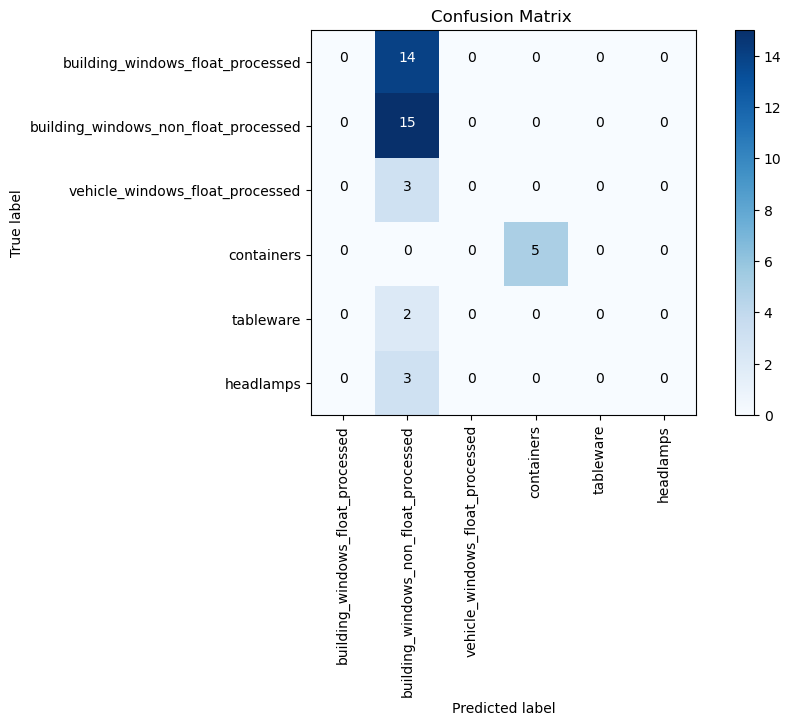

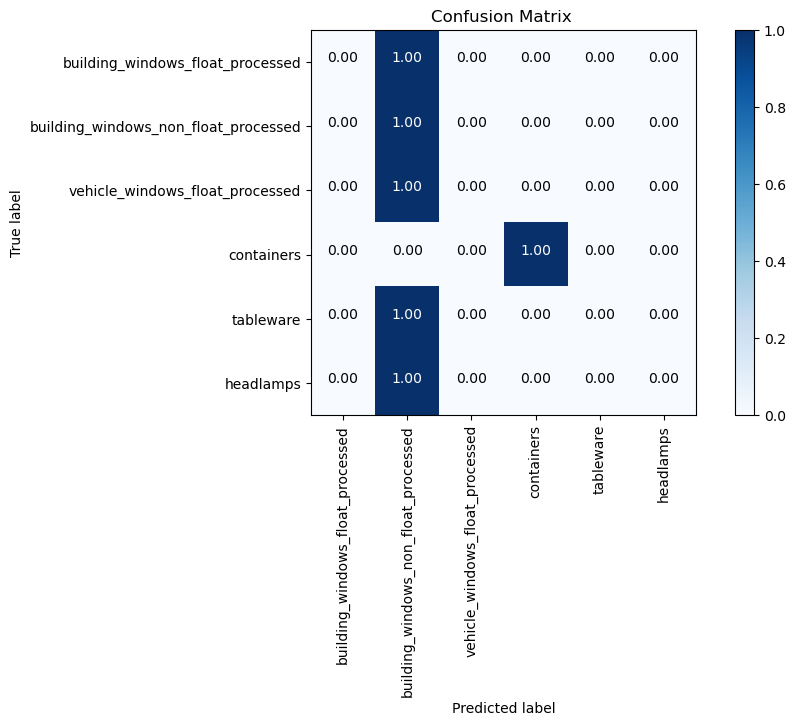

In [25]:
count_model(BaggingClassifier,
            StratifiedKFold(5),
            X,
            y,
            classes,
            params = {'estimator':svc, 'n_estimators':5},
            scaling = 'minmax',
            numeric_features = list(X.columns),
            results = True,
            plot = True,
            print_params = True)

Istotność zmiennych random forrest:

In [26]:
X, y, classes = prepare_dataset('wine')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print_results(calculate_metrics(y_test, y_pred))

Results for classifier
----
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 score:  1.0
  Mislabeled 0 out of 36




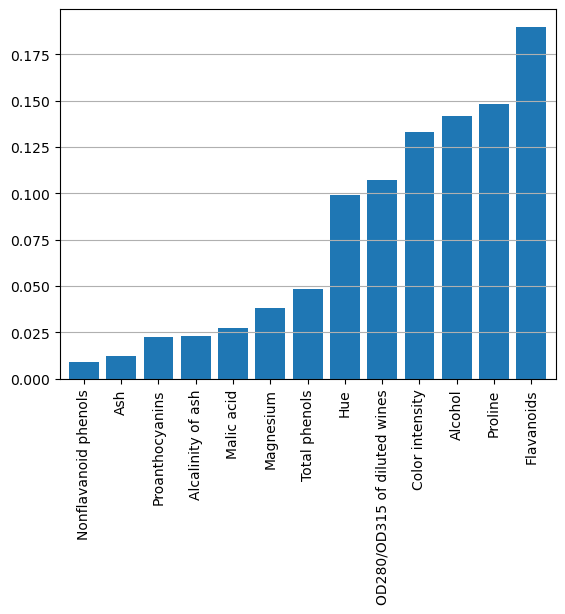

In [27]:
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_], axis = 0)

df = pd.Series(importances, index = X.columns).sort_values()

fig, ax = plt.subplots()

df.plot.bar(yerr = std, ax=ax, width = 0.8)
plt.grid(which = 'major', axis = 'y')

In [28]:
df

Nonflavanoid phenols            0.009065
Ash                             0.012054
Proanthocyanins                 0.022556
Alcalinity of ash               0.022775
Malic acid                      0.027301
Magnesium                       0.038387
Total phenols                   0.048217
Hue                             0.099229
OD280/OD315 of diluted wines    0.107333
Color intensity                 0.133157
Alcohol                         0.141808
Proline                         0.148192
Flavanoids                      0.189927
dtype: float64

#### XGBoost:

In [29]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [30]:
import xgboost as xgb

PARAMS:

 {'objective': 'multi:softprob', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None} 

RESULTS:

Results for classifier
----
  Accuracy:  0.983050847457627

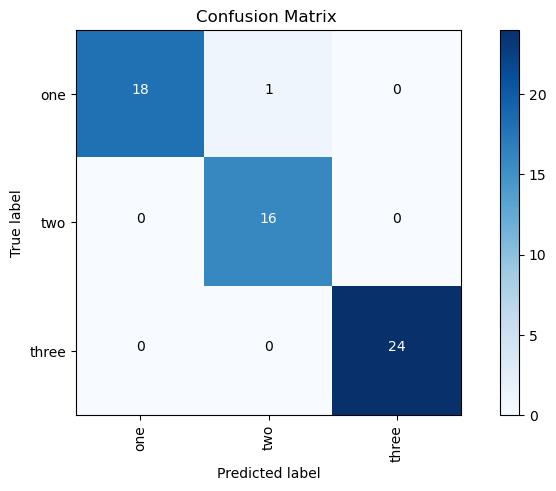

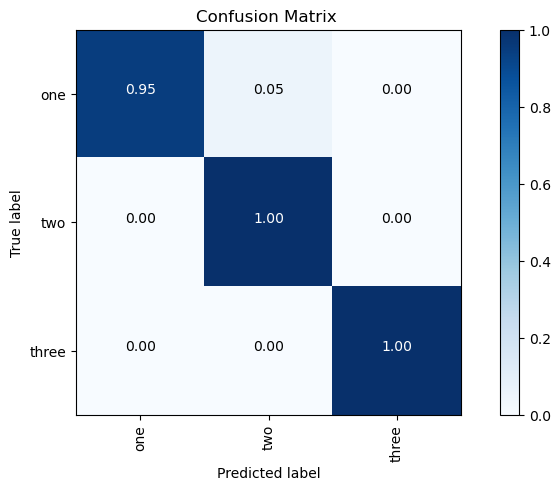

In [31]:
count_model(xgb.XGBClassifier,
            StratifiedKFold(3),
            X,
            y,
            classes,
            params = None,
            scaling = None,
            numeric_features = None,
            results = True,
            plot = True,
            print_params = True)

Importances

In [32]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print_results(calculate_metrics(y_test, y_pred))

Results for classifier
----
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 score:  1.0
  Mislabeled 0 out of 36




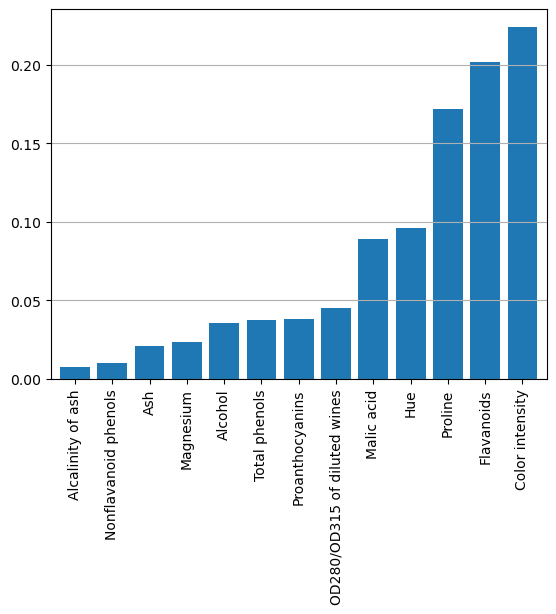

In [33]:
importances = model.feature_importances_


df = pd.Series(importances, index = X.columns).sort_values()

fig, ax = plt.subplots()

df.plot.bar(ax=ax, width = 0.8)
plt.grid(which = 'major', axis = 'y')

## Granice decyzyjne na sztucznie wygenerowanym zbiorze:

#### Bagging Classifier

C:\Users\kacpe\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


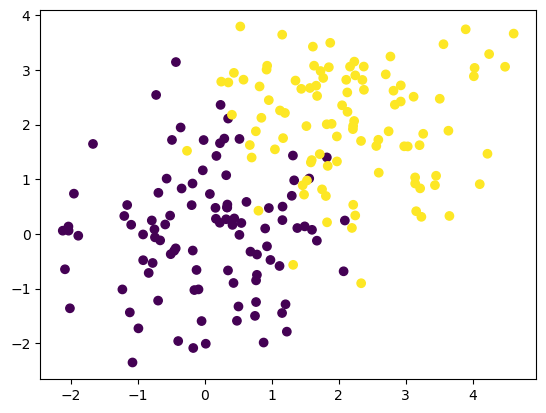

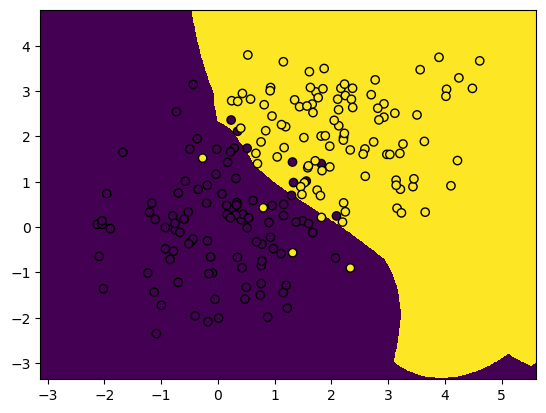

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2)),
                        np.random.normal(size=(100, 2), loc=2)))

train_labels = np.hstack((np.zeros(100), np.ones(100)))

# np.vstack - połaczenie tablic wertykalne
# np.hstack - połączenie tablic horyzontalne

fig, ax = plt.subplots()
ax.scatter(train_data[:,0], train_data[:,1], c =train_labels)

model = BaggingClassifier(base_estimator = SVC(kernel = 'rbf'), n_estimators = 5)
model.fit(train_data, train_labels)

x_min, x_max = train_data[:,0].min() -1, train_data[:,0].max() +1
y_min, y_max = train_data[:,1].min() -1, train_data[:,1].max() +1

xs, ys = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

y_pred = model.predict(np.column_stack((xs.flatten(),
                                       ys.flatten())))


y_pred_matrix = y_pred.reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, y_pred_matrix)
ax.scatter(train_data[:,0], train_data[:,1], c=train_labels, edgecolors = 'k')
plt.show()

#### Random Forest


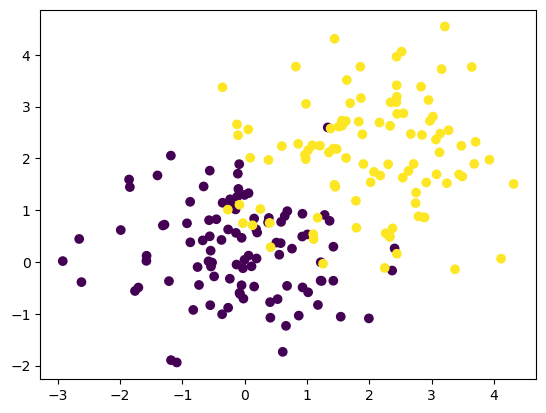

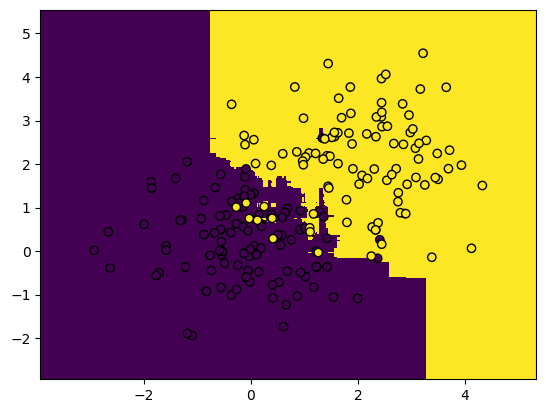

In [35]:
# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2)),
                        np.random.normal(size=(100, 2), loc=2)))

train_labels = np.hstack((np.zeros(100), np.ones(100)))

# np.vstack - połaczenie tablic wertykalne
# np.hstack - połączenie tablic horyzontalne

fig, ax = plt.subplots()
ax.scatter(train_data[:,0], train_data[:,1], c =train_labels)

model = RandomForestClassifier()
model.fit(train_data, train_labels)

x_min, x_max = train_data[:,0].min() -1, train_data[:,0].max() +1
y_min, y_max = train_data[:,1].min() -1, train_data[:,1].max() +1

xs, ys = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

y_pred = model.predict(np.column_stack((xs.flatten(),
                                       ys.flatten())))


y_pred_matrix = y_pred.reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, y_pred_matrix)
ax.scatter(train_data[:,0], train_data[:,1], c=train_labels, edgecolors = 'k')
plt.show()

#### Boosting


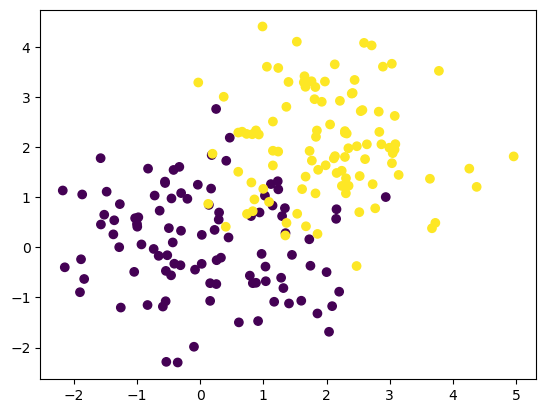

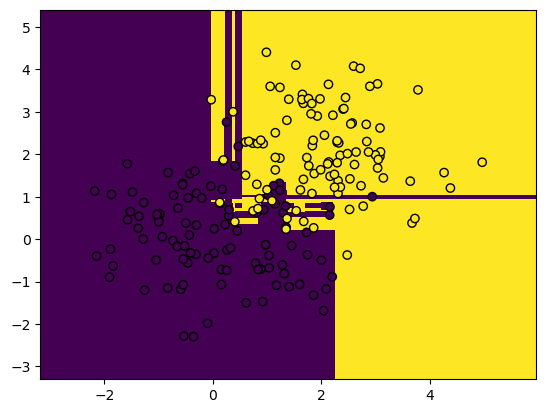

In [36]:
# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2)),
                        np.random.normal(size=(100, 2), loc=2)))

train_labels = np.hstack((np.zeros(100), np.ones(100)))

# np.vstack - połaczenie tablic wertykalne
# np.hstack - połączenie tablic horyzontalne

fig, ax = plt.subplots()
ax.scatter(train_data[:,0], train_data[:,1], c =train_labels)

model = xgb.XGBClassifier()
model.fit(train_data, train_labels)

x_min, x_max = train_data[:,0].min() -1, train_data[:,0].max() +1
y_min, y_max = train_data[:,1].min() -1, train_data[:,1].max() +1

xs, ys = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

y_pred = model.predict(np.column_stack((xs.flatten(),
                                       ys.flatten())))


y_pred_matrix = y_pred.reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, y_pred_matrix)
ax.scatter(train_data[:,0], train_data[:,1], c=train_labels, edgecolors = 'k')
plt.show()